## Predicting Total C% by machine learning using remote sensing and other environmental covariates

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import geopandas as gp
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import rasterio as rio
import earthpy.plot as ep
from rasterio.merge import merge
import earthpy.spatial as es
from osgeo import gdal, gdal_array
import warnings
warnings.filterwarnings("ignore")

### Load data from computer - All years - Sentinel data

In [2]:
all_years = pd.read_csv("all_data_Sentinel.csv", sep = ';')
all_years.dropna(subset='pH', inplace = True)
all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631 entries, 0 to 631
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Experiment           631 non-null    object 
 1   SP_ID                631 non-null    int64  
 2   sample_distance (m)  346 non-null    float64
 3   Field                631 non-null    object 
 4   Soil_Symbol          631 non-null    object 
 5   Soil                 631 non-null    object 
 6   Sample_Date          631 non-null    object 
 7   Month-year           631 non-null    object 
 8   Year                 631 non-null    int64  
 9   Sample_time          631 non-null    object 
 10  Easting              631 non-null    float64
 11  Northing             631 non-null    float64
 12  X                    631 non-null    float64
 13  Y                    631 non-null    float64
 14  pH                   631 non-null    float64
 15  BD_gcm3              342 non-null    flo

In [ ]:
# Convert Field,, Year and Soil to dummies and save the file
dat_dummies = pd.get_dummies(all_years, columns = ['Field','Year','Soil'])
dat_dummies.to_csv('new_files/dat_with_dummies_sentinel.csv', index = False)
dat_dummies.columns

In [ ]:
# Info
dat_dummies.info()

In [ ]:
# Split the dataset into training and validation
x = dat_dummies[['pH','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
       'B11', 'B12', 'NDVI', 'GNDVI', 'NDRE', 'NDMI', 'EVI', 'BSI',
       'Field_Bottom Burrows', 'Field_Burrows', 'Field_Dairy Corner',
       'Field_Dairy East', 'Field_Dairy North', 'Field_Dairy South',
       'Field_Golden Rove', 'Field_Great Field', 'Field_Higher Wyke Moor',
       'Field_Little Pecketsford', 'Field_Longlands East',
       'Field_Longlands North', 'Field_Longlands South', 'Field_Lower Wheaty',
       'Field_Lower Wyke Moor', 'Field_Middle Wyke Moor',
       'Field_Orchard Dean - Orchard Dean North',
       'Field_Orchard Dean - Orchard Dean South', 'Field_Orchard Dean North',
       'Field_Orchard Dean South', 'Field_Pecketsford',
       'Field_Pecketsford (whole)', 'Field_Poor Field', 'Field_Ware Park',
       'Year_2016', 'Year_2018', 'Year_2019', 'Year_2020', 'Year_2021',
       'Soil_Denbigh/ Cherubeer', 'Soil_Fladbury', 'Soil_Hallsworth',
       'Soil_Halstow']]
y = dat_dummies['C_total_%w/w']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 4, test_size = 0.25)

In [ ]:
# Baseline errors, and display average baseline error
baseline_errors = abs(y_test.mean() - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

In [ ]:
# Plot train and test datasets
y_train.plot(kind='hist', ec = 'black', color = 'skyblue')
y_test.plot(kind='hist', ec = 'black', color ='red')
plt.show()

### Run the models

### All years together

In [ ]:
# Linear Regression
m1 = LinearRegression().fit(x_train, y_train)
print('The R2 of the train is {}'.format(round(m1.score(x_train, y_train), 2)))
print('The R2 of the test is {}'.format(round(m1.score(x_test, y_test), 2)))

In [ ]:
# Gradient Boosting
m2 = GradientBoostingRegressor().fit(x_train, y_train)
print('The R2 of the train is {}'.format(round(m2.score(x_train, y_train), 2)))
print('The R2 of the test is {}'.format(round(m2.score(x_test, y_test), 2)))

In [ ]:
# Random Forest
m3 = RandomForestRegressor(n_estimators = 2500).fit(x_train, y_train)
print('The R2 of the train is {}'.format(round(m3.score(x_train, y_train), 2)))
print('The R2 of the test is {}'.format(round(m3.score(x_test, y_test), 2)))

In [ ]:
# Predict using Gradient boosting
y_pred = m2.predict(x_test)
plt.scatter(y_test, y_pred)

In [ ]:
# Print performance metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred), 2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred), 2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2))

In [ ]:
# Get numerical feature importances
importances = list(m2.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
plt.plot(y_train, 'ro', label = 'actual', color = 'red')
plt.plot(y_test, 'ro', label = 'prediction', color = 'blue')
plt.xticks(rotation = '60'); 
plt.legend()
plt.title('Actual and Predicted Values');

### By year

2016

In [3]:
dat_dummies2 = pd.get_dummies(all_years, columns = ['Soil'])
dat_dummies2

,Experiment,SP_ID,sample_distance (m),Field,Soil_Symbol,Sample_Date,Month-year,Year,Sample_time,Easting,...,NDVI,GNDVI,NDRE,NDMI,EVI,BSI,Soil_Denbigh/ Cherubeer,Soil_Fladbury,Soil_Hallsworth,Soil_Halstow
0,FP059,257,50.0,Ware Park,Fa,1/7/2016,2016-07,2016,14:10:00,265825.0000,...,0.76,0.69,0.21,0.42,0.89,-0.37,0,1,0,0
1,FP059,269,50.0,Ware Park,Hk,1/7/2016,2016-07,2016,11:35:00,265725.0000,...,0.76,0.64,0.17,0.37,0.84,-0.34,0,0,1,0
2,FP059,271,50.0,Ware Park,Fa,1/7/2016,2016-07,2016,14:25:00,265775.0000,...,0.82,0.72,0.21,0.44,0.98,-0.41,0,1,0,0
3,FP059,273,50.0,Ware Park,Hk,1/7/2016,2016-07,2016,11:55:00,265825.0000,...,0.77,0.65,0.18,0.39,0.88,-0.36,0,0,1,0
4,FP059,280,50.0,Ware Park,Fa,1/7/2016,2016-07,2016,11:20:00,265775.0000,...,0.77,0.64,0.17,0.39,0.88,-0.36,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,NW752-3S,2012,NaN,Middle Wyke Moor,Hw,9/12/2021,2021-12,2021,12:00:00,266286.9323,...,0.81,0.75,0.16,0.36,0.49,-0.29,0,0,0,1
628,NW752-3S,2010,NaN,Lower Wyke Moor,Hw,9/12/2021,2021-12,2021,12:00:00,266451.1332,...,0.92,0.82,0.13,0.46,0.67,-0.43,0,0,0,1
629,NW752-3S,2013,NaN,Dairy South,Hw,9/12/2021,2021-12,2021,12:00:00,266152.0651,...,0.92,0.79,0.14,0.45,0.69,-0.42,0,0,0,1
630,NW752-3S,2016,NaN,Dairy East,Hw,9/12/2021,2021-12,2021,12:00:00,266335.1610,...,0.92,0.82,0.13,0.44,0.75,-0.42,0,0,0,1


In [4]:
dat_dumies_2016 = dat_dummies2.loc[dat_dummies2['Year'] == 2016]
dat_dumies_2016

,Experiment,SP_ID,sample_distance (m),Field,Soil_Symbol,Sample_Date,Month-year,Year,Sample_time,Easting,...,NDVI,GNDVI,NDRE,NDMI,EVI,BSI,Soil_Denbigh/ Cherubeer,Soil_Fladbury,Soil_Hallsworth,Soil_Halstow
0,FP059,257,50.0,Ware Park,Fa,1/7/2016,2016-07,2016,14:10:00,265825.0,...,0.76,0.69,0.21,0.42,0.89,-0.37,0,1,0,0
1,FP059,269,50.0,Ware Park,Hk,1/7/2016,2016-07,2016,11:35:00,265725.0,...,0.76,0.64,0.17,0.37,0.84,-0.34,0,0,1,0
2,FP059,271,50.0,Ware Park,Fa,1/7/2016,2016-07,2016,14:25:00,265775.0,...,0.82,0.72,0.21,0.44,0.98,-0.41,0,1,0,0
3,FP059,273,50.0,Ware Park,Hk,1/7/2016,2016-07,2016,11:55:00,265825.0,...,0.77,0.65,0.18,0.39,0.88,-0.36,0,0,1,0
4,FP059,280,50.0,Ware Park,Fa,1/7/2016,2016-07,2016,11:20:00,265775.0,...,0.77,0.64,0.17,0.39,0.88,-0.36,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,FP059,402,50.0,Burrows,Hw,12/7/2016,2016-07,2016,15:07:00,265575.0,...,0.77,0.67,0.20,0.37,0.93,-0.34,0,0,0,1
343,FP059,404,50.0,Burrows,Hw,12/7/2016,2016-07,2016,14:38:00,265625.0,...,0.77,0.65,0.21,0.44,0.79,-0.41,0,0,0,1
344,FP059,406,50.0,Burrows,Hw,12/7/2016,2016-07,2016,14:30:00,265675.0,...,0.77,0.67,0.20,0.36,0.91,-0.33,0,0,0,1
345,FP059,422,50.0,Burrows,Hw,12/7/2016,2016-07,2016,14:54:00,265575.0,...,0.77,0.67,0.20,0.34,0.91,-0.31,0,0,0,1


In [5]:
dat_dumies_2016['Soil_Symbol'].unique()

array(['Fa', 'Hk', 'Dg_Chb', 'Hw'], dtype=object)

In [25]:
# Split dataset in training and testing
x_2016 = dat_dumies_2016[['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
       'B11', 'B12', 'NDVI', 'GNDVI', 'NDRE', 'NDMI', 'EVI', 'BSI',
       'Soil_Denbigh/ Cherubeer', 'Soil_Fladbury', 'Soil_Hallsworth',
       'Soil_Halstow']]
y_2016 = dat_dumies_2016['C_total_%w/w']
x_train_2016, x_test_2016, y_train_2016, y_test_2016 = train_test_split(x_2016, y_2016, test_size = 0.3)

In [26]:
# Baseline errors, and display average baseline error
baseline_errors_2016 = abs(y_test_2016.mean() - y_test_2016)
print('Average baseline error: ', round(np.mean(baseline_errors_2016), 2))

Average baseline error:  1.07


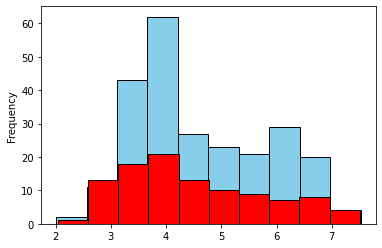

In [27]:
# Plot train and test datasets
y_train_2016.plot(kind='hist', ec = 'black', color = 'skyblue')
y_test_2016.plot(kind='hist', ec = 'black', color ='red')
plt.show()

In [28]:
# Linear Regression
lr_2016 = LinearRegression().fit(x_train_2016, y_train_2016)
print('The R2 of the train is {}'.format(round(lr_2016.score(x_train_2016, y_train_2016), 2)))
print('The R2 of the test is {}'.format(round(lr_2016.score(x_test_2016, y_test_2016), 2)))

The R2 of the train is 0.21
The R2 of the test is 0.03


In [29]:
# Gradient Boosting
gbr_2016 = GradientBoostingRegressor().fit(x_train_2016, y_train_2016)
print('The R2 of the train is {}'.format(round(gbr_2016.score(x_train_2016, y_train_2016), 2)))
print('The R2 of the test is {}'.format(round(gbr_2016.score(x_test_2016, y_test_2016), 2)))

The R2 of the train is 0.85
The R2 of the test is 0.06


In [30]:
# Random Forest
rf_2016 = RandomForestRegressor(n_estimators = 500).fit(x_train_2016, y_train_2016)
print('The R2 of the train is {}'.format(round(rf_2016.score(x_train_2016, y_train_2016), 2)))
print('The R2 of the test is {}'.format(round(rf_2016.score(x_test_2016, y_test_2016), 2)))

The R2 of the train is 0.86
The R2 of the test is 0.16


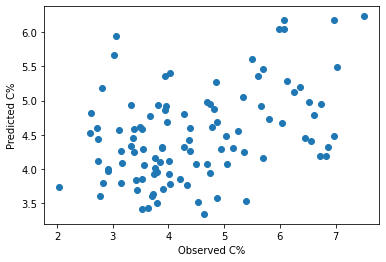

In [33]:
# Predict using Gradient boosting
y_pred_2016 = rf_2016.predict(x_test_2016)
plt.scatter(y_test_2016, y_pred_2016)
plt.xlabel("Observed C%")
plt.ylabel("Predicted C%")
plt.show()

In [34]:
# Print performance metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test_2016, y_pred_2016), 2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test_2016, y_pred_2016), 2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test_2016, y_pred_2016)), 2))

Mean Absolute Error: 0.92
Mean Squared Error: 1.36
Root Mean Squared Error: 1.17


In [35]:
# Get numerical feature importances
importance_2016 = list(rf_2016.feature_importances_)
feature_importances_2016 = [(feature, round(importance, 3)) for feature, importance in zip(x_train_2016.columns, importance_2016)]
feature_importances_2016 = sorted(feature_importances_2016, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances_2016];

Variable: B5                                       Importance: 0.121
Variable: B11                                      Importance: 0.11
Variable: B3                                       Importance: 0.096
Variable: NDRE                                     Importance: 0.087
Variable: B4                                       Importance: 0.082
Variable: B12                                      Importance: 0.073
Variable: B2                                       Importance: 0.065
Variable: B6                                       Importance: 0.056
Variable: B8                                       Importance: 0.051
Variable: B8A                                      Importance: 0.048
Variable: GNDVI                                    Importance: 0.041
Variable: NDMI                                     Importance: 0.039
Variable: B7                                       Importance: 0.028
Variable: NDVI                                     Importance: 0.027
Variable: BSI                      

In [36]:
## Load raster
with rio.open('C:/Users/neliq/Documents/NIF/Rothamsted/rasters/covs_s2a_soil_dummy_27700.tif') as covs:
    covs_array = covs.read()
    covs_meta = covs.profile
    covs_affine = covs.profile.pop('transform')
covs_array.shape

(20, 154, 178)

In [37]:
## load image data
img_RS = 'C:/Users/neliq/Documents/NIF/Rothamsted/rasters/covs_s2a_soil_dummy_27700.tif'

image = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((image.RasterYSize, image.RasterXSize, image.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(image.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = image.GetRasterBand(b + 1).ReadAsArray()
    

## Set the number of columns, rows and bands
rows = image.RasterYSize
cols = image.RasterXSize
bands = image.RasterCount

print('Image extent: {} x {} (row x col)'.format(rows, cols))
print('Number of Bands: {}'.format(bands))

Image extent: 154 x 178 (row x col)
Number of Bands: 20


In [38]:
## Reshape to (row*col, bands)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)
img_as_array.shape

(27412, 20)

In [39]:
## Predicting into the entire raster
soc_prediction = gbr_2016.predict(img_as_array)
soc_prediction = soc_prediction.reshape(img[:, :, 0].shape)
soc_prediction.shape

(154, 178)

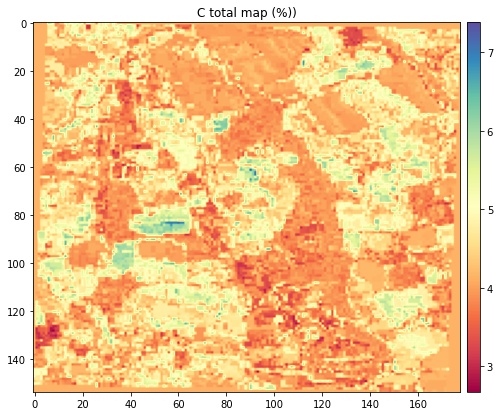

In [75]:
## Plotting the predicted map
fig, axs = plt.subplots(figsize=(8,8))
img = axs.imshow(soc_prediction, cmap = 'Spectral')
plt.title("C total map (%))")
cbar = ep.colorbar(img)
plt.show()

In [ ]:
# Export raster
soc_new = soc_prediction.reshape(1, 154,178)
with rio.open('soc_map_27700_3.tif', 'w', 
              driver = 'GTiff', 
              height = soc_prediction.shape[1], 
              width = soc_prediction.shape[0],
              count = 1,
              dtype = soc_prediction.dtype,
              transform = covs_affine) as dst:
    dst.write(soc_new)

In [72]:
## Add kriging raster
with rio.open('C:/Users/neliq/Documents/NIF/Rothamsted/datasets_RR/predicted_2016.tif') as pred_2016:
    krige_array = pred_2016.read()
    krige_meta = pred_2016.profile
    
krige_array = krige_array.reshape(400, 343)

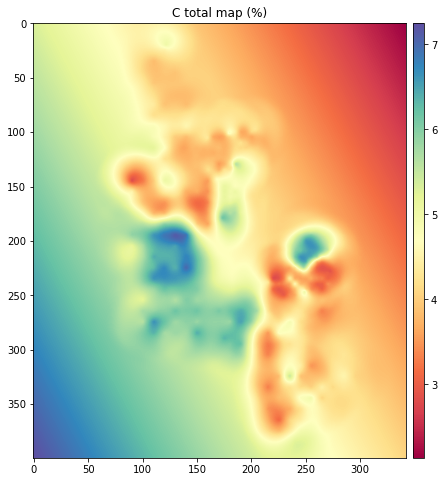

In [74]:
## Plotting the kriging map
fig, axs = plt.subplots(figsize=(8,8))
img = axs.imshow(krige_array, cmap = 'Spectral')
plt.title("C total map (%)")
cbar = ep.colorbar(img)
plt.show()

In [64]:
## Add kriging raster and soc map - Both were joined in qgis
with rio.open('C:/Users/neliq/Documents/NIF/Rothamsted/datasets_RR/soc_stack_27700_rec.tif') as preds:
    preds_array = preds.read()
    preds_meta = preds.profile

In [67]:
preds_array.shape

(2, 382, 305)

<Figure size 576x576 with 0 Axes>

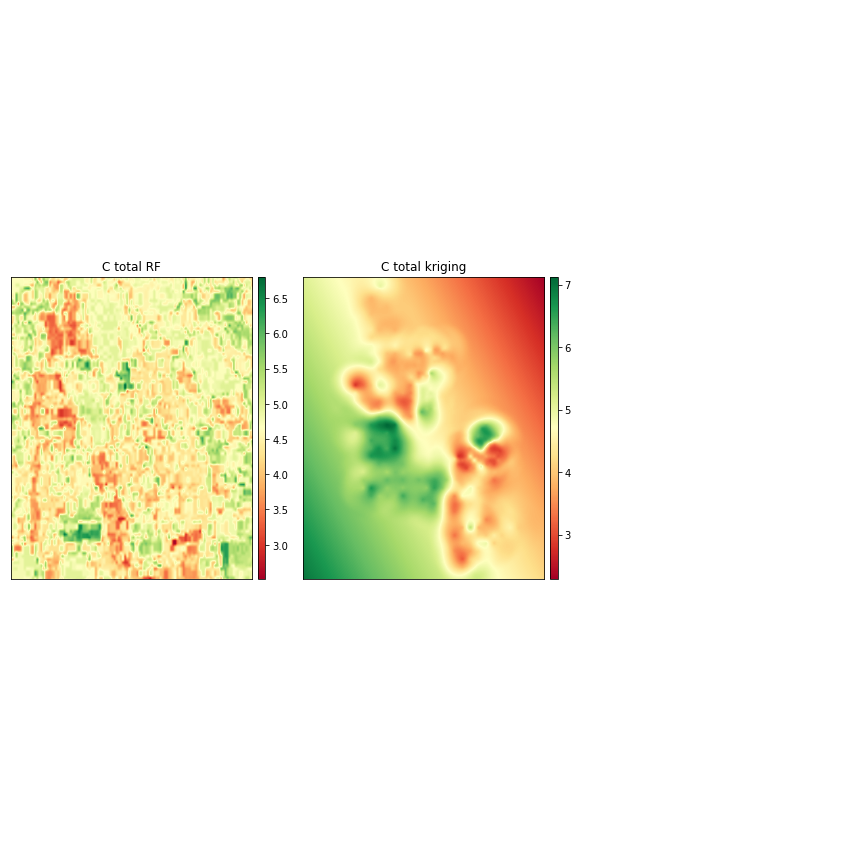

In [77]:
## Plotting the predicted map

band_titles=['C total RF', 'C total kriging']

plt.figure(figsize=(8,8))
fig = ep.plot_bands(preds_array,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)
plt.show()

In [ ]:
## End